# Periodogram Notebook

The aim of this notebook is to compute the PSD for each subject and each ROI and save those files to CSV for later use. This promotes a more efficient workflow for the classification task and will allow me to make changes to the PSD computation in a more modular way.

In [11]:
# Import necessary libraries

import sys
import os

# Add the project root directory to the Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(project_root)

# Now your imports should work
from src.data_loader import load_fmri_data, load_regressors
from src.roi_creation import fetch_aal_atlas, create_label_to_pseudo_index, get_pseudo_index, create_masker, extract_timeseries, extract_timeseries_for_roi
from src.region_lists import auditory_cortex_regions, visual_cortex_regions, motor_cortex_regions, dmn_regions, fpn_regions, salience_network_regions, limbic_system_regions
import pandas as pd
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import ast

### Load subjects and remove outliers

In [6]:
# Load empricial fMRI data and remove outliers

data_dir = '/Users/fdjim/Desktop/PDS_FULL/derivatives/fmriprep'
subjects = [
    "sub-003P", "sub-004P", "sub-005C", "sub-005P", "sub-006C",
    "sub-007C", "sub-007P", "sub-008P", "sub-009C", "sub-010P",
    "sub-013C", "sub-014C", "sub-014P", "sub-015C", "sub-015P",
    "sub-016C", "sub-016P", "sub-017C", "sub-018C", "sub-018P",
    "sub-019C", "sub-019P", "sub-020C", "sub-020P", "sub-021C",
    "sub-023P", "sub-024C", "sub-024P", "sub-025C", "sub-026C",
    "sub-027C", "sub-028C", "sub-029C", "sub-030C", "sub-030P",
    "sub-031C", "sub-031P", "sub-032P", "sub-033P", "sub-035P",
    "sub-037P", "sub-039P", "sub-041P", "sub-042P", "sub-043P",
    "sub-045P", "sub-046P", "sub-047P", "sub-048P", "sub-049P",
    "sub-050P", "sub-051P", "sub-052P", "sub-055P", "sub-056P",
    "sub-061P", "sub-066P", "sub-067P", "sub-069P", "sub-071P",
    "sub-075P"
]

outliers = ['sub-004P', 'sub-005C', 'sub-035P', 'sub-051P']
subjects = [subject for subject in subjects if subject not in outliers]

### Split the subjects into groups for the analysis

In [ ]:
# Split the subjects into groups for the analysis
diagnosis_df = pd.read_csv('/Users/fdjim/Desktop/PDS_FULL/participants.tsv', sep='\t')
# Create a dictionary mapping subject IDs to diagnosis
diagnosis_dict = dict(zip(diagnosis_df['participant_id'], diagnosis_df['dx']))
# Split subjects into groups based on diagnosis
subjects_hc = []
subjects_mdd = []
subjects_sz = []
for subject in subjects:
    if subject in diagnosis_dict:
        if diagnosis_dict[subject] == 'hc':
            subjects_hc.append(subject)
        elif diagnosis_dict[subject] == 'mdd':
            subjects_mdd.append(subject)
        elif diagnosis_dict[subject] == 'sz':
            subjects_sz.append(subject)
    else:
        print(f"Warning: Subject {subject} not found in diagnosis file")
print(f"HC: {subjects_hc}")
print(f"MDD: {subjects_mdd}")
print(f"SZ: {subjects_sz}")


In [ ]:
# Fetch atlas and create label to pseudo-index mapping
labels_aal, indices_aal, aal_img = fetch_aal_atlas()
pseudo_idx_aal = create_label_to_pseudo_index(labels_aal)
pseudo_idx_auditory = get_pseudo_index(pseudo_idx_aal, auditory_cortex_regions)
pseudo_idx_visual = get_pseudo_index(pseudo_idx_aal, visual_cortex_regions)
pseudo_idx_motor = get_pseudo_index(pseudo_idx_aal, motor_cortex_regions)
pseudo_idx_dmn = get_pseudo_index(pseudo_idx_aal, dmn_regions)
pseudo_idx_fpn = get_pseudo_index(pseudo_idx_aal, fpn_regions)
pseudo_idx_salience = get_pseudo_index(pseudo_idx_aal, salience_network_regions)
pseudo_idx_limbic = get_pseudo_index(pseudo_idx_aal, limbic_system_regions)



### Create masker object, bandpass filter and smooth the data

*Note that this process is computationally expensive and takes a while to run.*

In [ ]:
# Create masker object, bandpass filter and smooth the data
# Extract time series data for each group
masker = create_masker(aal_img, smoothing_fwhm=2, high_pass=0.01, low_pass=0.24, 
                       t_r=2, standardize=True)

ts_hc = []
ts_mdd = []
ts_sz = []
task = 'pds'
for group in [subjects_hc, subjects_mdd, subjects_sz]:
    fmri_imgs = load_fmri_data(data_dir, group, task)
    regressors = load_regressors(data_dir, group, task)
    # Extract time series data
    ts_group = extract_timeseries(masker, fmri_imgs, regressors)
    if group == subjects_hc:
        ts_hc.extend(ts_group)
    elif group == subjects_mdd:
        ts_mdd.extend(ts_group)
    elif group == subjects_sz:
        ts_sz.extend(ts_group)

print(f"HC time series: {len(ts_hc)}")
print(f"MDD time series: {len(ts_mdd)}")
print(f"SZ time series: {len(ts_sz)}")


#### Extract timeseries for each ROI and each subject

This also saves the time series to CSV files.

In [ ]:
# Process HC and save to CSV
time_series_dict_hc = extract_timeseries_for_roi(
    ts_hc,
    pseudo_idx_auditory,
    pseudo_idx_visual,
    pseudo_idx_motor,
    pseudo_idx_dmn,
    pseudo_idx_fpn,
    pseudo_idx_salience,
    pseudo_idx_limbic,
    subjects_hc,
    "HC"
)

# Convert dictionary to wide format DataFrame
data_list = []
for subject_id, roi_dict in time_series_dict_hc.items():
    for roi, timeseries in roi_dict.items():
        # Create a row with subject, roi, and all timepoints
        row_data = {
            'subject': subject_id,
            'roi': roi,
        }
        # Add each timepoint as a column
        for t in range(timeseries.shape[0]):
            row_data[f'timepoint_{t}'] = timeseries[t]
        data_list.append(row_data)

# Create DataFrame and save to CSV
df_wide = pd.DataFrame(data_list)
df_wide.to_csv('timeseries_hc_wide.csv', index=False)
print(f"Saved DataFrame with shape: {df_wide.shape}")

In [ ]:
# # Process MDD and save to CSV
# time_series_dict_mdd = extract_timeseries_for_roi(
#     ts_mdd,
#     pseudo_idx_auditory,
#     pseudo_idx_visual,
#     pseudo_idx_motor,
#     pseudo_idx_dmn,
#     pseudo_idx_fpn,
#     pseudo_idx_salience,
#     pseudo_idx_limbic,
#     subjects_mdd,
#     "MDD"
# )

# # Convert dictionary to wide format DataFrame
# data_list = []
# for subject_id, roi_dict in time_series_dict_mdd.items():
#     for roi, timeseries in roi_dict.items():
#         row_data = {
#             'subject': subject_id,
#             'roi': roi,
#         }
#         for t in range(timeseries.shape[0]):
#             row_data[f'timepoint_{t}'] = timeseries[t]
#         data_list.append(row_data)

# # Create DataFrame and save to CSV
# df_wide = pd.DataFrame(data_list)
# df_wide.to_csv('timeseries_mdd_wide.csv', index=False)
# print(f"Saved DataFrame with shape: {df_wide.shape}")

In [ ]:
# # Process SZ and save to CSV
# time_series_dict_sz = extract_timeseries_for_roi(
#     ts_sz,
#     pseudo_idx_auditory,
#     pseudo_idx_visual,
#     pseudo_idx_motor,
#     pseudo_idx_dmn,
#     pseudo_idx_fpn,
#     pseudo_idx_salience,
#     pseudo_idx_limbic,
#     subjects_sz,
#     "SZ"
# )

# # Convert dictionary to wide format DataFrame
# data_list = []
# for subject_id, roi_dict in time_series_dict_sz.items():
#     for roi, timeseries in roi_dict.items():
#         row_data = {
#             'subject': subject_id,
#             'roi': roi,
#         }
#         for t in range(timeseries.shape[0]):
#             row_data[f'timepoint_{t}'] = timeseries[t]
#         data_list.append(row_data)

# # Create DataFrame and save to CSV
# df_wide = pd.DataFrame(data_list)
# df_wide.to_csv('timeseries_sz_wide.csv', index=False)
# print(f"Saved DataFrame with shape: {df_wide.shape}")

### Load the timseries data from CSV files

In case you want to use this notebook to compute the PSD, you can load the timeseries data from the CSV files.

In [9]:
import pandas as pd
import numpy as np
from typing import Union, List, Dict, Tuple
import matplotlib.pyplot as plt

def process_time_series(file_path: str) -> Dict[Tuple[str, str], pd.DataFrame]:
    """
    Process time series data from a CSV file for multiple subjects and ROIs.
    
    Parameters:
    -----------
    file_path : str
        Path to the CSV file containing the time series data
        
    Returns:
    --------
    Dict[Tuple[str, str], pd.DataFrame]
        Dictionary with (subject, roi) tuples as keys and processed DataFrames as values
    """
    try:
        # Read the CSV file
        df = pd.read_csv(file_path)
        
        # Get timepoint columns
        timepoint_cols = [col for col in df.columns if col.startswith('timepoint_')]
        print(f"Found {len(timepoint_cols)} timepoint columns")
        
        def parse_array_string(array_str: str) -> List[float]:
            """Parse a string representation of an array into a list of floats"""
            try:
                if pd.isna(array_str) or array_str == '[':  # Handle empty or invalid entries
                    return None
                # Remove brackets and split by whitespace
                cleaned = array_str.strip('[]')
                # Handle multiple spaces and/or tabs
                values = [x for x in cleaned.split() if x]
                return [float(x) for x in values]
            except Exception as e:
                print(f"Error parsing array string: {array_str}")
                return None

        # Dictionary to store processed data
        processed_data = {}
        
        # Process each subject-ROI combination
        for idx, row in df.iterrows():
            subject = row['subject']
            roi = row['roi']
            
            # Process timepoint values
            timepoint_values = []
            valid_data = True
            
            for col in timepoint_cols:
                values = parse_array_string(row[col])
                if values is None:
                    valid_data = False
                    break
                timepoint_values.append(values)
            
            if not valid_data or not timepoint_values:
                print(f"Skipping invalid data for subject {subject}, ROI {roi}")
                continue
                
            # Get number of voxels
            n_voxels = len(timepoint_values[0])
            
            # Reorganize data by voxel
            voxel_series = [[] for _ in range(n_voxels)]
            for timepoint in timepoint_values:
                for voxel_idx in range(n_voxels):
                    voxel_series[voxel_idx].append(timepoint[voxel_idx])
            
            # Create DataFrame for this subject-ROI combination
            subject_roi_df = pd.DataFrame(voxel_series)
            subject_roi_df.columns = [f'timepoint_{i}' for i in range(len(timepoint_values))]
            subject_roi_df.index.name = 'voxel'
            
            # Store in dictionary
            processed_data[(subject, roi)] = subject_roi_df
            
        print(f"\nProcessed {len(processed_data)} subject-ROI combinations")
        return processed_data
        
    except Exception as e:
        print(f"Error processing file: {str(e)}")
        print(f"File path: {file_path}")
        raise

def plot_subject_roi_timeseries(processed_data: Dict[Tuple[str, str], pd.DataFrame],
                              subject: str, roi: str,
                              voxel_indices: Union[int, List[int]] = 0,
                              figsize: tuple = (15, 5)):
    """
    Plot time series for specific subject, ROI, and voxels.
    """
    # Check if subject-ROI combination exists
    if (subject, roi) not in processed_data:
        print(f"No data found for subject {subject}, ROI {roi}")
        return
    
    data = processed_data[(subject, roi)]
    
    if isinstance(voxel_indices, int):
        voxel_indices = [voxel_indices]
    
    plt.figure(figsize=figsize)
    for voxel_idx in voxel_indices:
        if voxel_idx >= len(data):
            print(f"Warning: Voxel index {voxel_idx} out of range")
            continue
        plt.plot(data.iloc[voxel_idx], label=f'Voxel {voxel_idx}')
    
    plt.xlabel('Timepoint')
    plt.ylabel('Signal Value')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()

# def plot_subject_roi_timeseries(processed_data: Dict[Tuple[str, str], pd.DataFrame],
#                               subject: str, roi: str,
#                               voxel_indices: Union[int, List[int]] = 0,
#                               figsize: tuple = (15, 5)):
#     """
#     Plot time series for specific subject, ROI, and voxels.
    
#     Parameters:
#     -----------
#     processed_data : Dict[Tuple[str, str], pd.DataFrame]
#         Dictionary containing processed time series data
#     subject : str
#         Subject ID to plot
#     roi : str
#         ROI to plot
#     voxel_indices : int or list of int
#         Index or indices of the voxels to plot
#     figsize : tuple
#         Figure size for the plot
#     """
#     # Check if subject-ROI combination exists
#     if (subject, roi) not in processed_data:
#         print(f"No data found for subject {subject}, ROI {roi}")
#         print("Available combinations:")
#         for subj, r in processed_data.keys():
#             print(f"Subject: {subj}, ROI: {r}")
#         return
    
#     data = processed_data[(subject, roi)]
    
#     if isinstance(voxel_indices, int):
#         voxel_indices = [voxel_indices]
    
#     plt.figure(figsize=figsize)
#     for voxel_idx in voxel_indices:
#         if voxel_idx >= len(data):
#             print(f"Warning: Voxel index {voxel_idx} out of range")
#             continue
#         plt.plot(data.iloc[voxel_idx], label=f'Voxel {voxel_idx}')
    
#     plt.title(f'Time Series for Subject {subject}, ROI {roi}')
#     plt.xlabel('Timepoint')
#     plt.ylabel('Signal Value')
#     plt.grid(True, alpha=0.3)
#     plt.legend()
#     plt.tight_layout()
#     plt.show()

def get_available_combinations(processed_data: Dict[Tuple[str, str], pd.DataFrame]) -> pd.DataFrame:
    """
    Get a DataFrame showing all available subject-ROI combinations and their properties.
    """
    rows = []
    for (subject, roi), data in processed_data.items():
        rows.append({
            'subject': subject,
            'roi': roi,
            'n_voxels': len(data),
            'n_timepoints': len(data.columns)
        })
    return pd.DataFrame(rows)

### Save the processed data to CSV

**This is currently a workaround for the poor job I did when processing the time series to CSV lol -- i will fix it later**

In [3]:
def save_processed_data(processed_data: Dict[Tuple[str, str], pd.DataFrame], 
                     output_path: str) -> None:
    """
    Save processed time series data to CSV file with easily parseable format.
    
    Parameters:
    -----------
    processed_data : Dict[Tuple[str, str], pd.DataFrame]
        Dictionary containing processed time series data
    output_path : str
        Path where to save the CSV file
    """
    # Create a list to store all rows
    rows = []
    
    # Process each subject-ROI combination
    for (subject, roi), df in processed_data.items():
        for voxel in range(len(df)):
            # Convert time series to string with comma separation, no brackets
            time_series = df.iloc[voxel].values
            values_str = ','.join(f"{x:.10f}" for x in time_series)  # Using 10 decimal places
            
            rows.append({
                'subject': subject,
                'roi': roi,
                'voxel': voxel,
                'values': values_str
            })
    
    # Convert to DataFrame and save
    output_df = pd.DataFrame(rows)
    output_df.to_csv(output_path, index=False)
    print(f"Saved data to {output_path}")
    print(f"Shape: {output_df.shape}")

def load_processed_data(file_path: str) -> Dict[Tuple[str, str], pd.DataFrame]:
    """
    Load processed time series data from CSV file.
    
    Parameters:
    -----------
    file_path : str
        Path to the CSV file containing the processed data
        
    Returns:
    --------
    Dict[Tuple[str, str], pd.DataFrame]
        Dictionary with (subject, roi) tuples as keys and processed DataFrames as values
    """
    try:
        # Read the CSV file
        df = pd.read_csv(file_path)
        
        if 'values' not in df.columns:
            raise ValueError("File format not recognized")
        
        # Convert the data back into the dictionary format
        processed_data = {}
        
        # Group by subject and ROI
        for (subject, roi), group in df.groupby(['subject', 'roi']):
            # Convert string arrays back to numeric arrays
            voxel_series = []
            for _, row in group.iterrows():
                # Split the values string and convert to floats
                values = np.array([float(x) for x in row['values'].split(',')])
                voxel_series.append(values)
            
            # Create DataFrame for this subject-ROI combination
            subject_roi_df = pd.DataFrame(voxel_series)
            subject_roi_df.columns = [f'timepoint_{i}' for i in range(len(voxel_series[0]))]
            subject_roi_df.index.name = 'voxel'
            
            # Store in dictionary
            processed_data[(subject, roi)] = subject_roi_df
            
        print(f"Loaded {len(processed_data)} subject-ROI combinations")
        return processed_data
        
    except Exception as e:
        print(f"Error loading file: {str(e)}")
        print(f"File path: {file_path}")
        raise


Processing HC data...
Found 312 timepoint columns

Processed 140 subject-ROI combinations
Saved data to processed_timeseries_hc.csv
Shape: (720, 4)
Loaded 140 subject-ROI combinations

Processing MDD data...
Found 312 timepoint columns

Processed 126 subject-ROI combinations
Saved data to processed_timeseries_mdd.csv
Shape: (648, 4)
Loaded 126 subject-ROI combinations

Processing SZ data...
Found 312 timepoint columns

Processed 133 subject-ROI combinations
Saved data to processed_timeseries_sz.csv
Shape: (684, 4)
Loaded 133 subject-ROI combinations


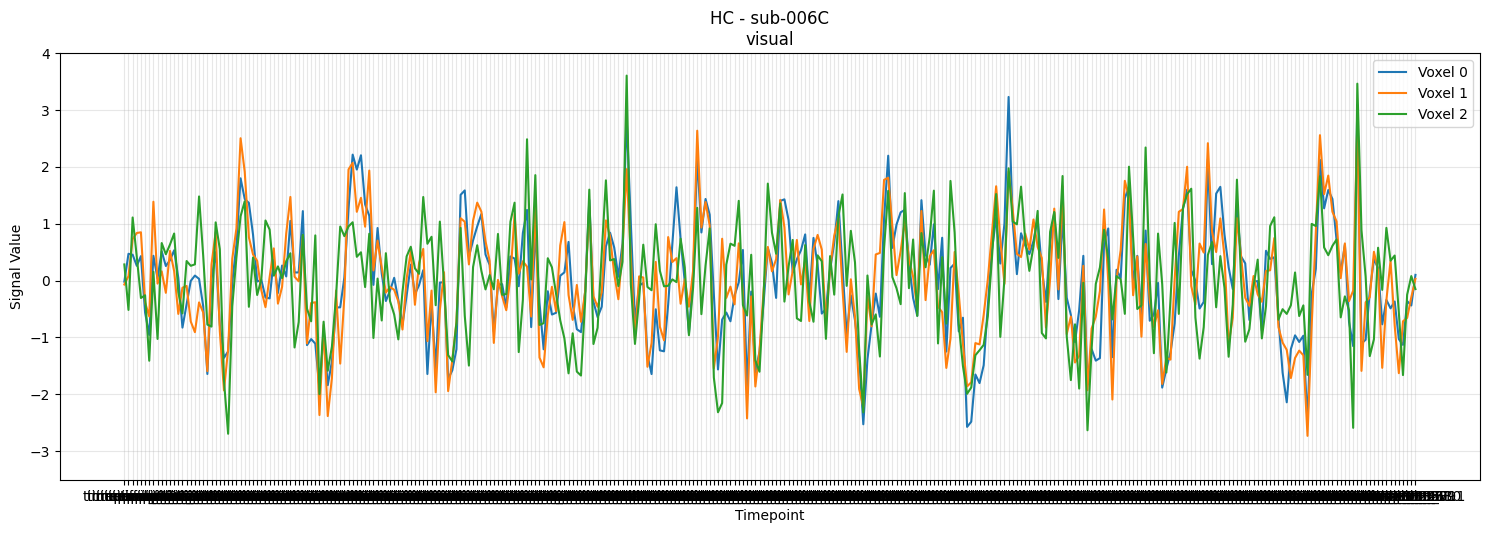

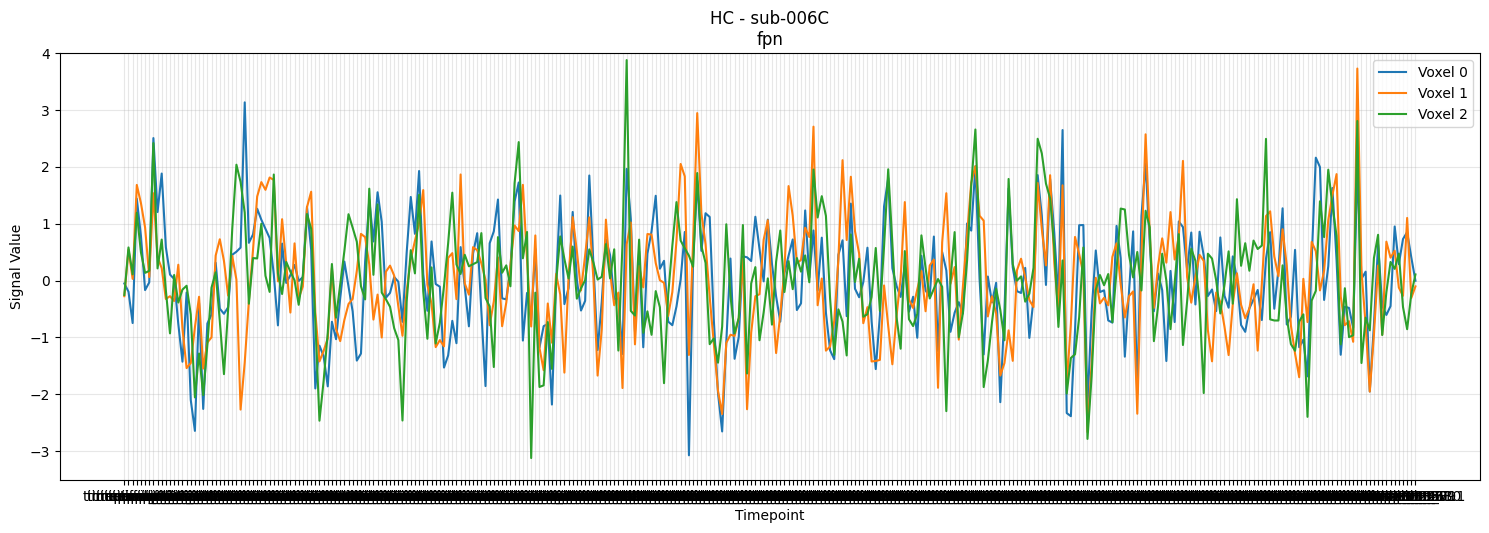

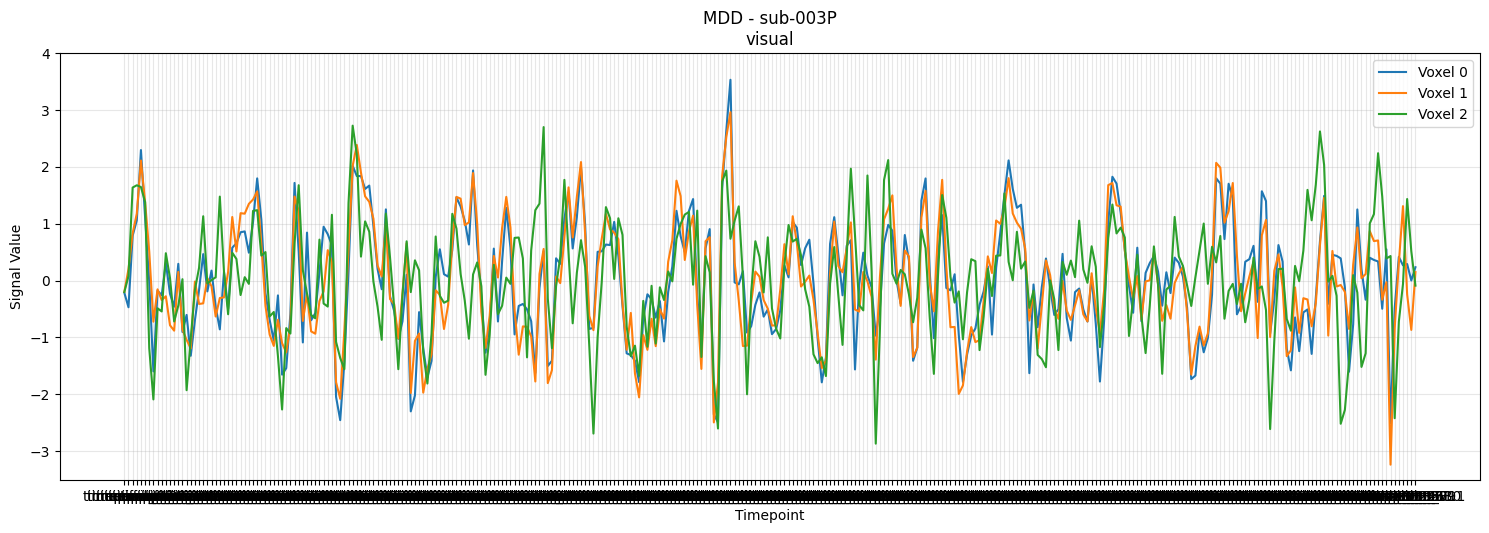

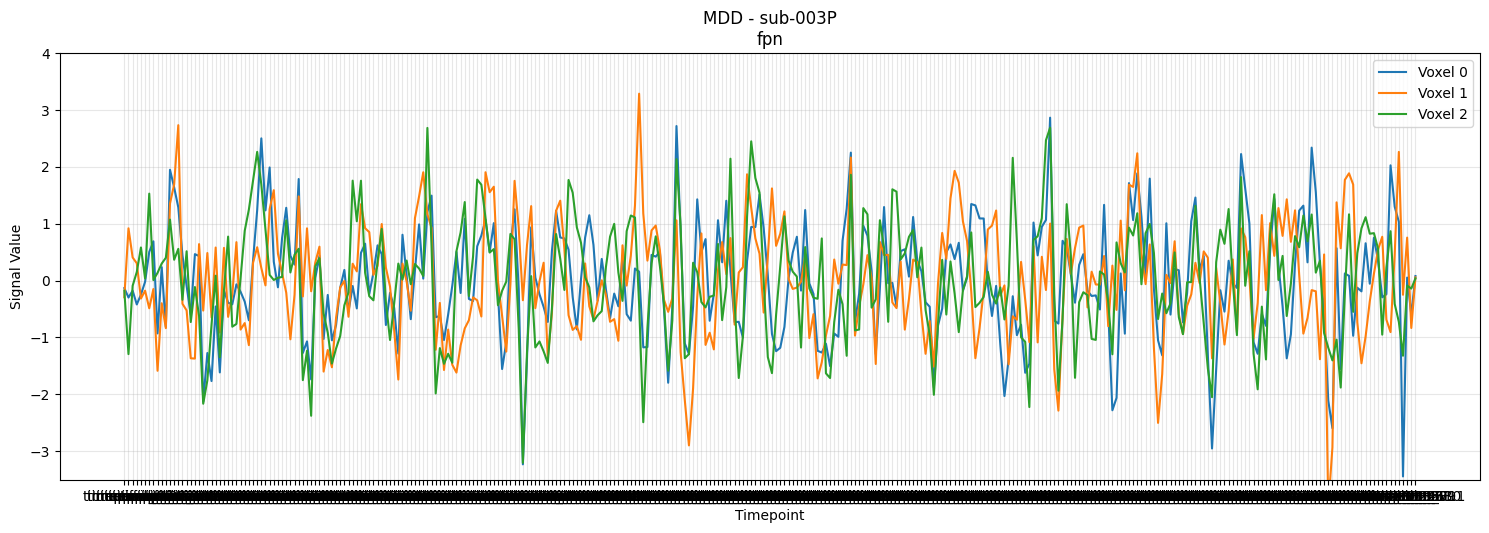

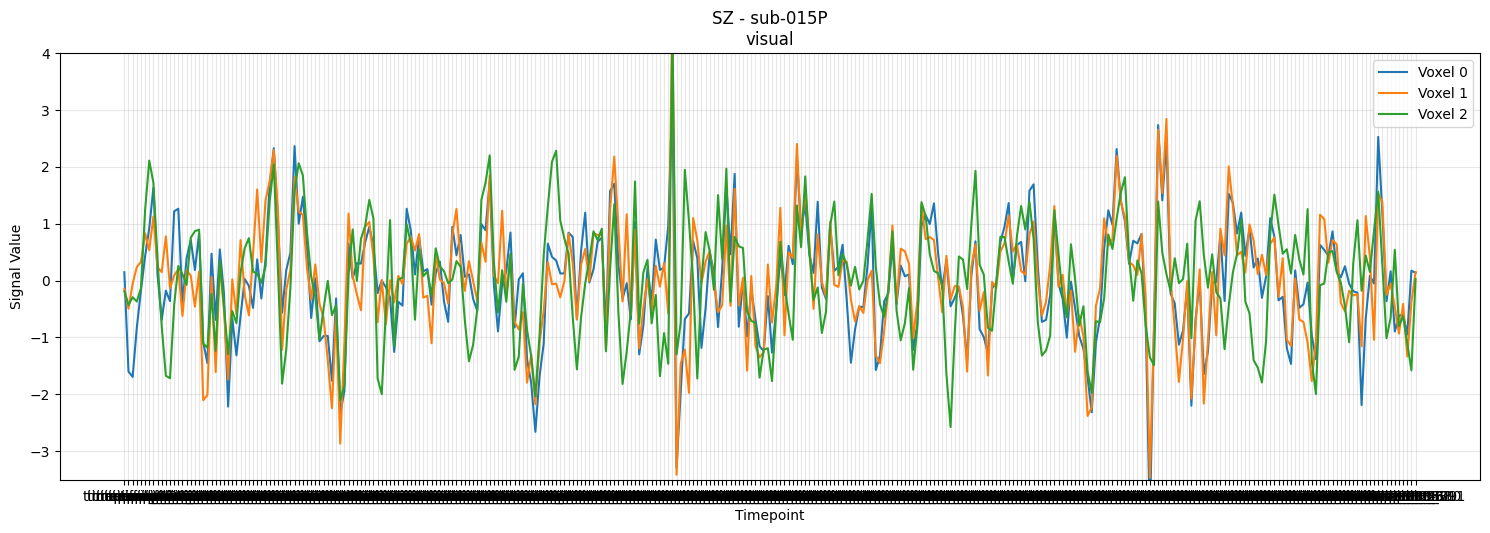

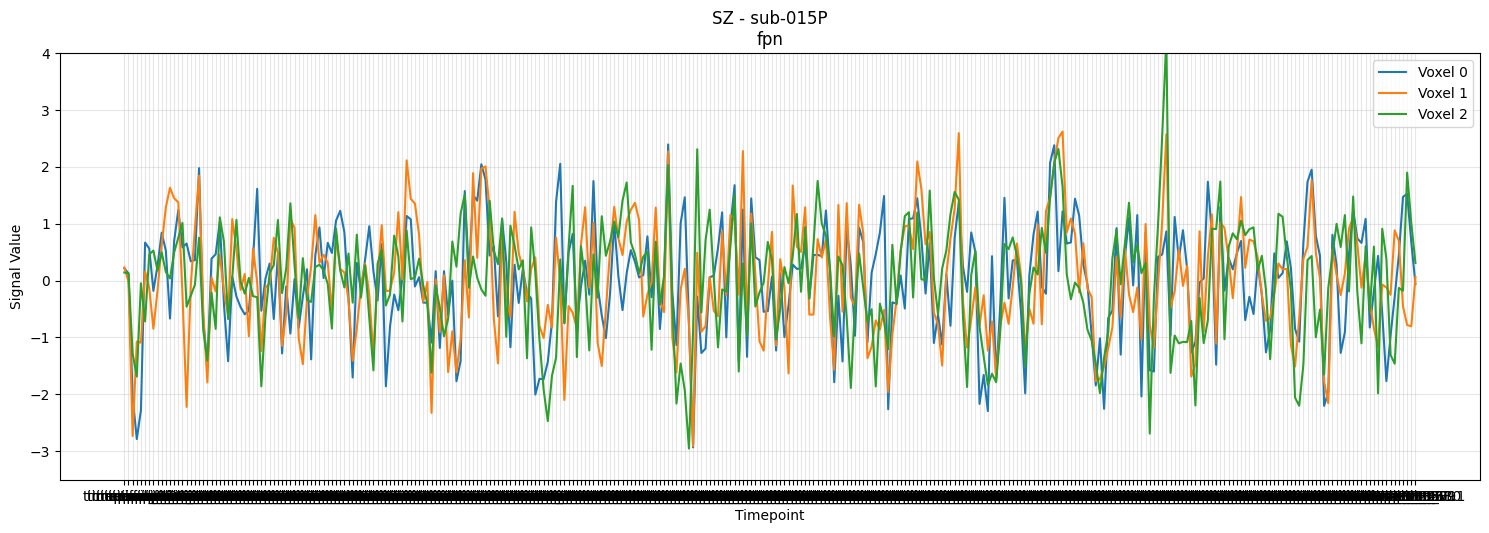

In [10]:
# Process and save data for all groups
group_files = {
    'HC': 'timeseries_hc_wide.csv',
    'MDD': 'timeseries_mdd_wide.csv',
    'SZ': 'timeseries_sz_wide.csv'
}

processed_data_all = {}
for group, file in group_files.items():
    print(f"\nProcessing {group} data...")
    processed_data = process_time_series(file)
    save_processed_data(processed_data, f'processed_timeseries_{group.lower()}.csv')
    
    # Load back and store in dictionary
    loaded_data = load_processed_data(f'processed_timeseries_{group.lower()}.csv')
    processed_data_all[group] = loaded_data

# Plot first subject from each group for selected ROIs
rois_to_plot = ['visual', 'fpn']  # Example ROIs

# Set fixed y-axis limits
y_min, y_max = -3.5, 4

# Plot with consistent y-axis limits
for group, data in processed_data_all.items():
    # Get first subject in this group
    first_subject = list(data.keys())[0][0]  # [0][0] because keys are (subject, roi) tuples
    
    for roi in rois_to_plot:
        plot_subject_roi_timeseries(data, 
                                  subject=first_subject, 
                                  roi=roi, 
                                  voxel_indices=[0, 1, 2])
        plt.ylim(y_min, y_max)
        plt.title(f'{group} - {first_subject}\n{roi}')

### Compute the PSD for each subject and each ROI

This function also saves the PSD to CSV files.

In [12]:
from scipy import signal
import numpy as np
import pandas as pd

def calculate_psd(timeseries_df):
    """
    Calculates the power spectral density (PSD) for time series data stored in long format.
    
    Parameters:
    -----------
    timeseries_df : pd.DataFrame
        DataFrame with columns: subject, roi, voxel, values
        where values contains comma-separated time series data
    
    Returns:
    --------
    tuple: (frequencies, psd_dict)
        frequencies : np.ndarray
            Array of frequency values
        psd_dict : dict
            Nested dictionary with structure:
            {subject_id: {
                roi_name: array of mean PSD values
            }}
    """
    psd_dict = {}
    frequencies = None  # Will be set on first calculation
    
    # Group the data by subject and ROI
    for (subject, roi), group in timeseries_df.groupby(['subject', 'roi']):
        # Initialize subject dictionary if needed
        if subject not in psd_dict:
            psd_dict[subject] = {}
            
        # Convert string values to numpy arrays
        timeseries_data = np.array([
            np.array([float(x) for x in row['values'].split(',')])
            for _, row in group.iterrows()
        ])
        
        # Calculate PSD for all voxels at once
        # timeseries_data shape should be (n_voxels, n_timepoints)
        freqs, psd_values = signal.periodogram(timeseries_data, 
                                             fs=1/2,  # Assuming same sampling rate
                                             window='hamming', 
                                             nfft=None, 
                                             detrend='constant', 
                                             return_onesided=True, 
                                             scaling='density', 
                                             axis=1)  # Calculate along time axis
        
        # Store frequencies only once since they're the same for all calculations
        if frequencies is None:
            frequencies = freqs
        
        # Take mean across voxels
        mean_psd = np.mean(psd_values, axis=0)  # Average across voxels
        
        # Store just the PSD values
        psd_dict[subject][roi] = mean_psd
        
    return frequencies, psd_dict

def plot_psd(frequencies, psd_dict, subjects=None, rois=None, figsize=(12, 6)):
    """
    Plot the PSD results for specified subjects and ROIs.
    
    Parameters:
    -----------
    frequencies : np.ndarray
        Array of frequency values
    psd_dict : dict
        The PSD dictionary returned by calculate_psd
    subjects : list or None
        List of subjects to plot. If None, plots all subjects
    rois : list or None
        List of ROIs to plot. If None, plots all ROIs
    figsize : tuple
        Figure size
    """
    
    # If subjects/rois not specified, use all available
    if subjects is None:
        subjects = list(psd_dict.keys())
    if rois is None:
        # Get unique ROIs across all subjects
        rois = set()
        for subject in subjects:
            rois.update(psd_dict[subject].keys())
        rois = sorted(list(rois))
    
    # Create subplot grid
    n_subjects = len(subjects)
    n_rois = len(rois)
    
    fig, axes = plt.subplots(n_subjects, n_rois, 
                            figsize=(figsize[0]*n_rois/2, figsize[1]*n_subjects/2),
                            squeeze=False)
    
    # Find global min and max PSD values for consistent y-axis
    min_psd = 10**(-0.5)
    max_psd = 10**(2)
    
    # Plot each combination
    for i, subject in enumerate(subjects):
        for j, roi in enumerate(rois):
            ax = axes[i, j]
            
            if roi in psd_dict[subject]:
                psd_values = psd_dict[subject][roi]
                ax.semilogy(frequencies, psd_values)
                ax.grid(True)
                
                # Set x-axis limits to match passband
                ax.set_xlim(0.01, 0.24)
                # Set consistent y-axis limits
                ax.set_ylim(min_psd, max_psd)
                
                # Labels
                if i == n_subjects-1:
                    ax.set_xlabel('Frequency (Hz)')
                if j == 0:
                    ax.set_ylabel('PSD')
                
                ax.set_title(f'{subject}\n{roi}')
            else:
                ax.set_visible(False)
    
    plt.tight_layout()
    plt.show()



Processing HC data...

Processing MDD data...

Processing SZ data...


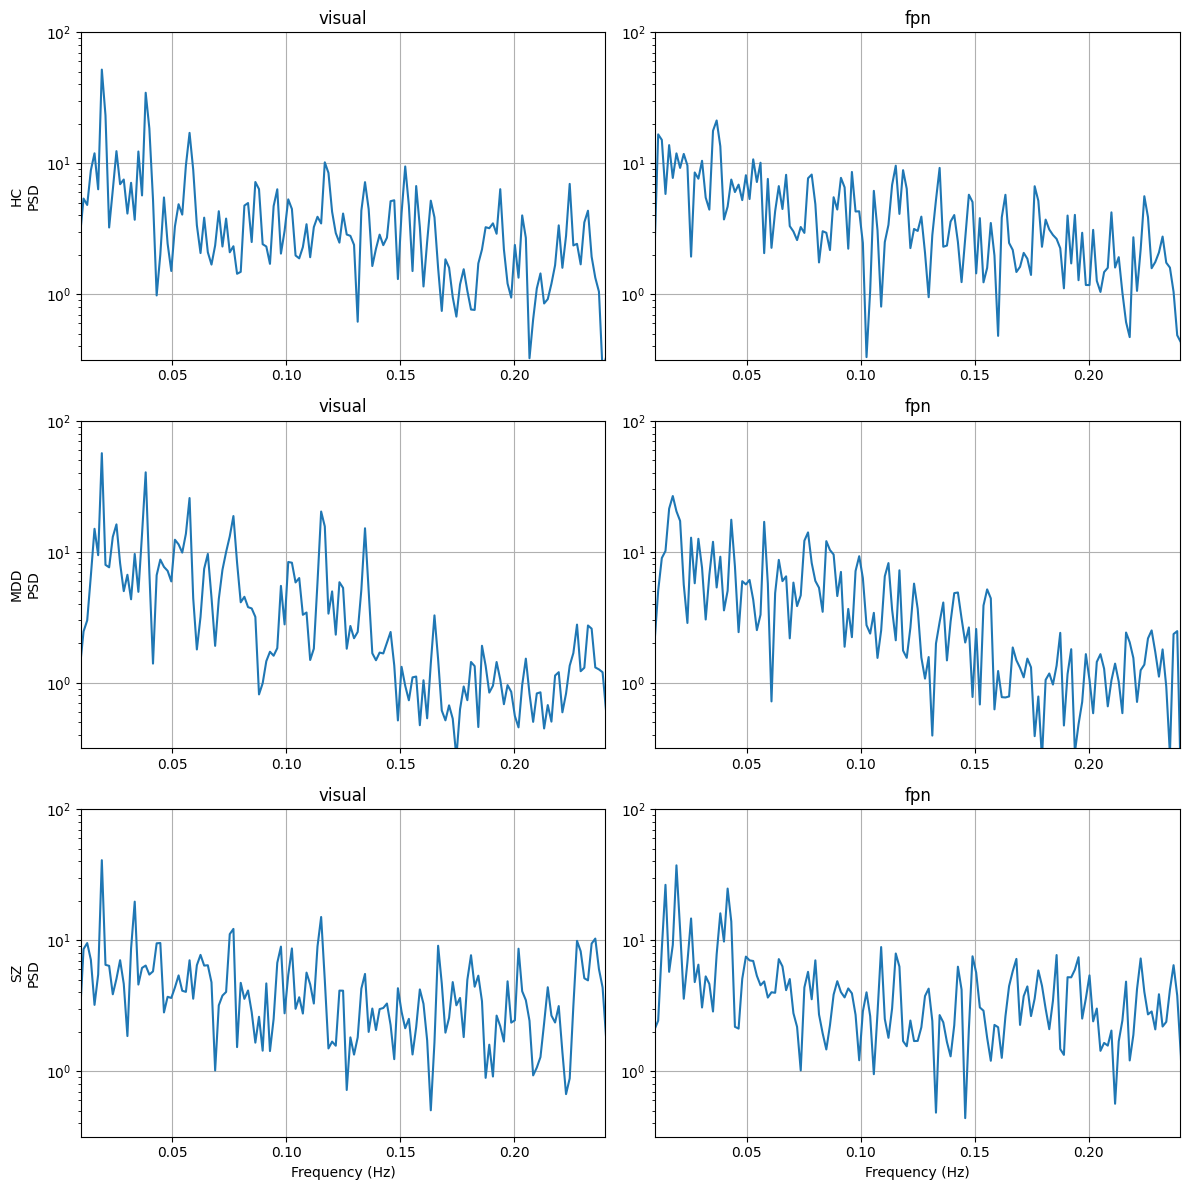

In [13]:
# Load PSD data for each group
group_files = {
    'HC': 'processed_timeseries_hc.csv',
    'MDD': 'processed_timeseries_mdd.csv',
    'SZ': 'processed_timeseries_sz.csv'
}

# Dictionary to store PSD results for each group
psd_results_all = {}
freqs_all = {}

# Calculate PSD for each group
for group, file in group_files.items():
    print(f"\nProcessing {group} data...")
    timeseries_df = pd.read_csv(file)
    freqs, psd_results = calculate_psd(timeseries_df)
    psd_results_all[group] = psd_results
    freqs_all[group] = freqs

# Plot first subject from each group for visual and FPN ROIs
rois_to_plot = ['visual', 'fpn']

# Create a figure with subplots
fig, axes = plt.subplots(len(group_files), len(rois_to_plot), 
                        figsize=(12, 12),
                        squeeze=False)

# Find global min and max PSD values for consistent y-axis
min_psd = 10**(-0.5)
max_psd = 10**(2)

# Plot each group and ROI
for i, (group, psd_results) in enumerate(psd_results_all.items()):
    # Get first subject in this group
    first_subject = list(psd_results.keys())[0]
    freqs = freqs_all[group]
    
    for j, roi in enumerate(rois_to_plot):
        ax = axes[i, j]
        
        if roi in psd_results[first_subject]:
            psd_values = psd_results[first_subject][roi]
            ax.semilogy(freqs, psd_values)
            ax.grid(True)
            
            # Set x-axis limits to match passband
            ax.set_xlim(0.01, 0.24)
            # Set consistent y-axis limits
            ax.set_ylim(min_psd, max_psd)
            
            # Labels
            if i == len(group_files)-1:
                ax.set_xlabel('Frequency (Hz)')
            if j == 0:
                ax.set_ylabel(f'{group}\nPSD')
            
            ax.set_title(f'{roi}')

plt.tight_layout()
plt.show()

In [17]:
def save_psd_data(frequencies, psd_dict, output_path):
    """
    Save PSD data in long format with frequencies as columns.
    
    Parameters:
    -----------
    frequencies : np.ndarray
        Array of frequency values
    psd_dict : dict
        Nested dictionary with structure:
        {subject_id: {roi_name: array of PSD values}}
    output_path : str
        Path where to save the CSV file
    
    Returns:
    --------
    pd.DataFrame
        The created DataFrame before saving (for potential further use)
    """
    # Create list to store rows
    rows = []
    
    # Process each subject and ROI
    for subject in psd_dict:
        for roi in psd_dict[subject]:
            psd_values = psd_dict[subject][roi]
            
            # Create a row with subject, roi, and all frequency values
            row = {
                'subject': subject,
                'roi': roi
            }
            # Add frequency columns with formatted names (avoiding scientific notation)
            for freq, psd_val in zip(frequencies, psd_values):
                # Format frequency to 6 decimal places to avoid scientific notation
                freq_name = f"freq_{freq:.6f}"
                row[freq_name] = float(psd_val)  # Ensure float type
                
            rows.append(row)
    
    # Create DataFrame
    df = pd.DataFrame(rows)
    
    # Save to CSV
    df.to_csv(output_path, index=False, float_format='%.10f')  # Specify float format
    print(f"Saved PSD data to {output_path}")
    print(f"Shape: {df.shape}")
    
    return df

def load_psd_data(file_path):
    """
    Load PSD data from the saved CSV format back into the frequency, dictionary format.
    
    Parameters:
    -----------
    file_path : str
        Path to the CSV file containing the PSD data
    
    Returns:
    --------
    tuple: (frequencies, psd_dict)
        frequencies : np.ndarray
            Array of frequency values
        psd_dict : dict
            Nested dictionary with structure:
            {subject_id: {roi_name: array of PSD values}}
    """
    # Read the CSV
    df = pd.read_csv(file_path)
    
    # Get frequency columns (those starting with 'freq_')
    freq_cols = [col for col in df.columns if col.startswith('freq_')]
    
    # Extract frequencies from column names
    frequencies = np.array([float(col.split('_')[1]) for col in freq_cols])
    
    # Create PSD dictionary
    psd_dict = {}
    
    # Process each row
    for _, row in df.iterrows():
        subject = row['subject']
        roi = row['roi']
        
        # Initialize subject dict if needed
        if subject not in psd_dict:
            psd_dict[subject] = {}
            
        # Get PSD values for this subject/ROI and ensure they're float64
        psd_values = row[freq_cols].values.astype(np.float64)
        
        # Store in dictionary
        psd_dict[subject][roi] = psd_values
    
    return frequencies, psd_dict

def get_freq_band(df, min_freq, max_freq):
    """
    Helper function to select frequency bands from the DataFrame.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame containing PSD data
    min_freq : float
        Minimum frequency to include
    max_freq : float
        Maximum frequency to include
    
    Returns:
    --------
    pd.DataFrame
        DataFrame with only the selected frequency bands
    """
    freq_cols = [col for col in df.columns if col.startswith('freq_')]
    freqs = np.array([float(col.split('_')[1]) for col in freq_cols])
    mask = (freqs >= min_freq) & (freqs <= max_freq)
    selected_cols = ['subject', 'roi'] + [freq_cols[i] for i in range(len(freq_cols)) if mask[i]]
    return df[selected_cols]

In [33]:
# Process each group
group_files = {
    'HC': 'processed_timeseries_hc.csv',
    'MDD': 'processed_timeseries_mdd.csv',
    'SZ': 'processed_timeseries_sz.csv'
}

# Define frequency band
# min_freq = 0.01
# max_freq = 0.1
freq_band_1 = (0.112179, 0.125, 0.137821) # 10 % window
freq_band_2 = (0.027244, 0.03125, 0.035256) # 13 % window

band_name_1 = f"{freq_band_1[0]:.2f}_{freq_band_1[1]:.2f}hz"
band_name_2 = f"{freq_band_2[0]:.2f}_{freq_band_2[1]:.2f}hz"

for group, file in group_files.items():
    print(f"\nProcessing {group} data...")
    # Load timeseries data
    timeseries_df = pd.read_csv(file)
    
    # Calculate PSD
    freqs, psd_results = calculate_psd(timeseries_df)
    
    # Save PSD data
    psd_df = save_psd_data(freqs, psd_results, f'psd_data_{group.lower()}.csv')
    
    # Get specific frequency bands and save
    band_df_1 = get_freq_band(psd_df, min_freq=freq_band_1[0], max_freq=freq_band_1[1])
    band_df_2 = get_freq_band(psd_df, min_freq=freq_band_2[0], max_freq=freq_band_2[1])
    band_df_1.to_csv(f'psd_band_{group.lower()}_{band_name_1}.csv', index=False)
    band_df_2.to_csv(f'psd_band_{group.lower()}_{band_name_2}.csv', index=False)

# Later, you can load back any group's data like this:
loaded_data = {}
for group in group_files.keys():
    freqs, psd = load_psd_data(f'psd_data_{group.lower()}.csv')
    loaded_data[group] = (freqs, psd)


Processing HC data...
Saved PSD data to psd_data_hc.csv
Shape: (140, 159)

Processing MDD data...
Saved PSD data to psd_data_mdd.csv
Shape: (126, 159)

Processing SZ data...
Saved PSD data to psd_data_sz.csv
Shape: (133, 159)
